## UNET CNN

In [1]:
from ReadData import *
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn import svm
# from sklearn.model_selection import cross_val_score
import tensorflow as tf

In [2]:
def readData(path, getTargetName = False):
    # print(getTargetName)
    data = getEMData(path)
    target = []
    field = []
    freq = []
    if getTargetName:
        targetName = []
        upper_case = [char for char in path if char.isupper()]
        target_name = path[path.index(upper_case[0]):path.index(upper_case[1])]

    for i in range(0, len(data)):
        target.append(data[i].target)
        field.append(data[i].Esct.real)
        freq.append(data[i].freq)
        if getTargetName: targetName.append(target_name)

    field = np.array(field)
    target = np.array(target)
    freq = np.array(freq)
    if getTargetName: targetName = np.array(targetName)

    result = (field, target, freq)
    if getTargetName: result = (field, target, freq, targetName)
    return result

In [21]:
fieldCirc, targetCirc, freqCirc, shapeCirc = readData(path = "./CircleData/", getTargetName=True)

fieldCirc = fieldCirc[np.where(freqCirc == 1e9)]
targetCirc = targetCirc[np.where(freqCirc == 1e9)]
freqCirc = freqCirc[np.where(freqCirc == 1e9)]

fieldCirc_transformed = np.reshape(fieldCirc, (fieldCirc.shape[0], fieldCirc.shape[1], fieldCirc.shape[2], 1))
targetCirc_transformed = np.reshape(targetCirc, (targetCirc.shape[0], targetCirc.shape[1], targetCirc.shape[2], 1))

field_train, field_test, target_train, target_test, freq_train, freq_test= train_test_split(
    fieldCirc_transformed, targetCirc_transformed, freqCirc, test_size=0.20, random_state=42)

Read 1470 samples


In [39]:
[field_train.shape, target_train.shape]

[(872, 24, 24, 1), (872, 50, 50, 1)]

In [4]:
fieldMNIST, targetMNIST, freqMNIST = readData(path = "./MNIST_UNET/", getTargetName=False)

fieldMNIST_transformed = np.reshape(fieldMNIST, (fieldMNIST.shape[0], fieldMNIST.shape[1], fieldMNIST.shape[2], 1))
targetMNIST_transformed = np.reshape(targetMNIST, (targetMNIST.shape[0], targetMNIST.shape[1], targetMNIST.shape[2], 1))

fieldMNIST_train, fieldMNIST_test, targetMNIST_train, targetMNIST_test= train_test_split(
    fieldMNIST_transformed, targetMNIST_transformed, test_size=0.20, random_state=42)

fieldMNIST_train, fieldMNIST_val, targetMNIST_train, targetMNIST_val= train_test_split(
    fieldMNIST_train, targetMNIST_train, test_size=0.20, random_state=42)

Read 520 samples


In [5]:
[fieldMNIST_train.shape,targetMNIST_train.shape, fieldMNIST_val.shape, targetMNIST_val.shape]

[(332, 24, 24, 1), (332, 35, 35, 1), (84, 24, 24, 1), (84, 35, 35, 1)]

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation, Input, Concatenate, AveragePooling2D,Add, Cropping2D

In [7]:
def unet(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(256, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(256, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(128, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(64, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    up3 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv4)
    # skip2 = Concatenate(axis=-1)([conv1, up2])
    conv5 = Conv2D(32, 3, padding='same')(up3)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(32, 3, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # Up-sample to (35, 35, 1)
    # conv5 = Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same')(conv4)

    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    # Cropping to the desired size (35, 35)
    cropped_output = Cropping2D(((7, 6), (7, 6)))(output)
    # skip3 = Concatenate(axis=-1)([input, cropped_output])


    model = Model(inputs=inputs, outputs=cropped_output)

    # skip3 = Add()([inputs, conv5])

    #     # Average pooling
    # output = AveragePooling2D(pool_size=(1, 1))(skip3)

    # model = Model(inputs=inputs, outputs=conv5)

    return model

In [8]:
inputMNIST_shape = fieldMNIST_train.shape[1:]
model_unet = unet(inputMNIST_shape)
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 24, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 24, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 24, 24, 64)   0           ['batch_normalization[0][0]']

In [9]:
from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

Try with suggested SGD, and logarithmic decay for learning rate

In [10]:
init_lr = 1e-3
final_lr = 1e-8
total_epoch = 200

In [51]:


def log_learning_rate(num_epoch):
    return np.logspace(np.log10(init_lr), np.log10(final_lr), num=num_epoch, endpoint=True)

def lr_scheduler(epoch, lr):
    return log_learning_rate(total_epoch)[epoch]

earlyStop = EarlyStopping(monitor='loss',patience=3)

# def SGD_opt(model):
#     lr_callback = LearningRateScheduler(lr_scheduler)
#     optimizer = tf.keras.optimizers.SGD(learning_rate=init_lr, momentum=0.99)
#     model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = 'accuracy')
#     return model.fit(x = fieldMNIST_train, y = targetMNIST_train, batch_size = 1, epochs = total_epoch, 
#                      callbacks = [lr_callback, EarlyStopping(monitor='loss',patience=3)])#stop when seeing no loss change in 3 consecutive epochs


In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)
model_unet.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = 'accuracy')
model_unet.fit(x = fieldMNIST_train, y = targetMNIST_train, validation_data=(fieldMNIST_val, targetMNIST_val), batch_size = 20, epochs = total_epoch, 
               callbacks = [EarlyStopping(monitor='loss',patience=5)])

Epoch 1/200
17/17 [==============================] - 7s 357ms/step - loss: 0.0362 - accuracy: 0.9428 - val_loss: 0.1025 - val_accuracy: 0.9574
Epoch 2/200
17/17 [==============================] - 6s 332ms/step - loss: 0.0319 - accuracy: 0.9457 - val_loss: 0.0902 - val_accuracy: 0.9531
Epoch 3/200
17/17 [==============================] - 6s 368ms/step - loss: 0.0300 - accuracy: 0.9469 - val_loss: 0.0794 - val_accuracy: 0.9533
Epoch 4/200
17/17 [==============================] - 8s 456ms/step - loss: 0.0294 - accuracy: 0.9475 - val_loss: 0.0673 - val_accuracy: 0.9505
Epoch 5/200
17/17 [==============================] - 9s 543ms/step - loss: 0.0297 - accuracy: 0.9471 - val_loss: 0.0704 - val_accuracy: 0.9513
Epoch 6/200
17/17 [==============================] - 9s 511ms/step - loss: 0.0285 - accuracy: 0.9481 - val_loss: 0.0646 - val_accuracy: 0.9493
Epoch 7/200
17/17 [==============================] - 9s 555ms/step - loss: 0.0283 - accuracy: 0.9481 - val_loss: 0.0650 - val_accuracy: 0.9507

In [44]:
# sgd_opt_model = SGD_opt(model_unet)

Epoch 1/200
416/416 [==============================] - 18s 36ms/step - loss: 0.4786 - accuracy: 0.1752 - lr: 1.0000e-06
Epoch 2/200
416/416 [==============================] - 19s 45ms/step - loss: 0.4557 - accuracy: 0.2068 - lr: 9.7712e-07
Epoch 3/200
416/416 [==============================] - 18s 44ms/step - loss: 0.4305 - accuracy: 0.2456 - lr: 9.5477e-07
Epoch 4/200
416/416 [==============================] - 20s 48ms/step - loss: 0.4059 - accuracy: 0.2870 - lr: 9.3293e-07
Epoch 5/200
416/416 [==============================] - 16s 39ms/step - loss: 0.3819 - accuracy: 0.3316 - lr: 9.1159e-07
Epoch 6/200
416/416 [==============================] - 17s 41ms/step - loss: 0.3586 - accuracy: 0.3787 - lr: 8.9074e-07
Epoch 7/200
416/416 [==============================] - 16s 38ms/step - loss: 0.3360 - accuracy: 0.4283 - lr: 8.7036e-07
Epoch 8/200
416/416 [==============================] - 17s 41ms/step - loss: 0.3142 - accuracy: 0.4801 - lr: 8.5045e-07
Epoch 9/200
416/416 [===================

In [17]:
pred1 = model_unet.predict(fieldMNIST_test)

4/4 [==============================] - 1s 113ms/step


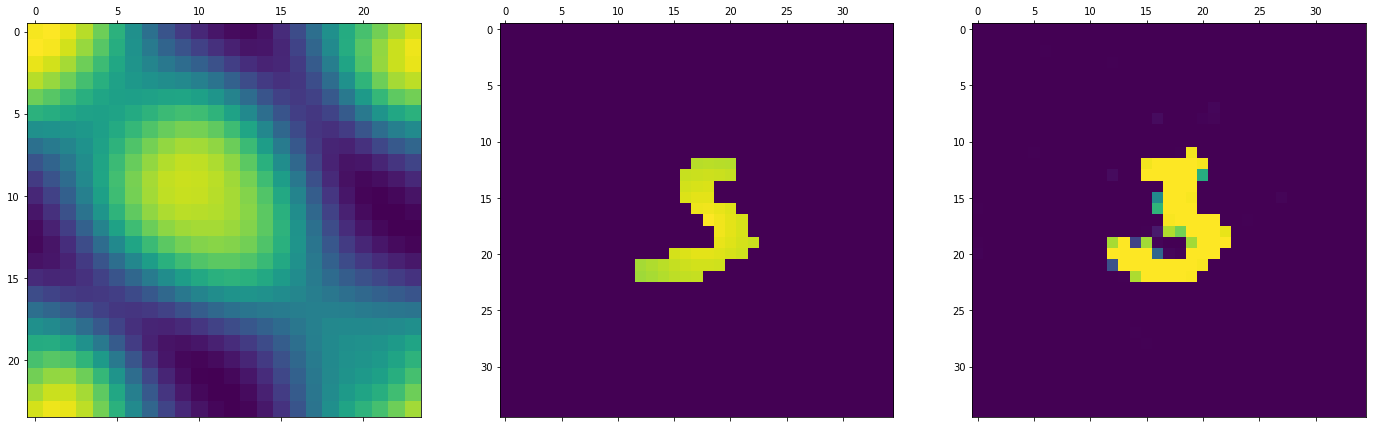

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[1])
axs[1].matshow(targetMNIST_test[1])
axs[2].matshow(pred1[1])

plt.show()

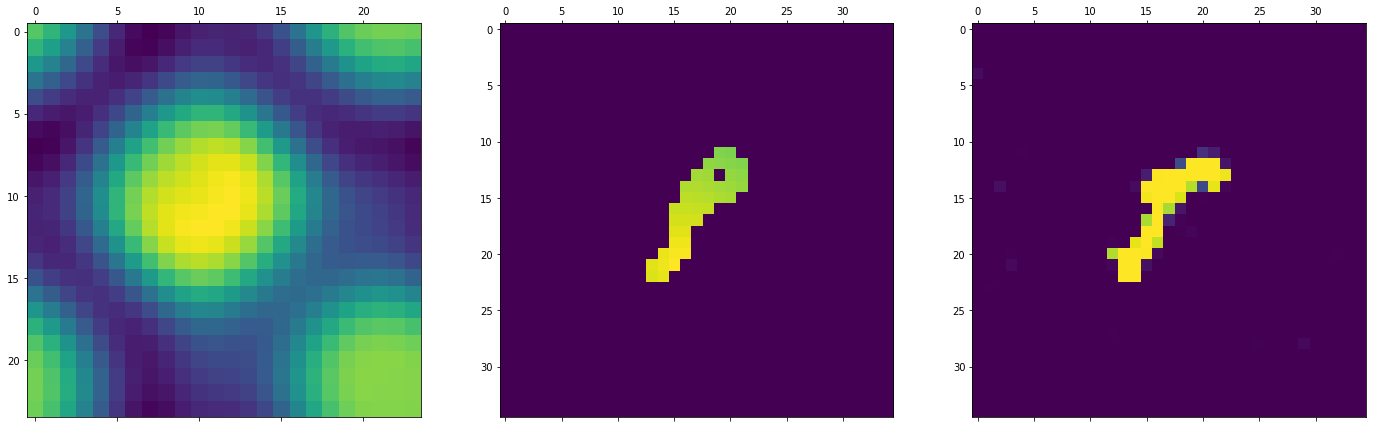

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[2])
axs[1].matshow(targetMNIST_test[2])
axs[2].matshow(pred1[2])

plt.show()

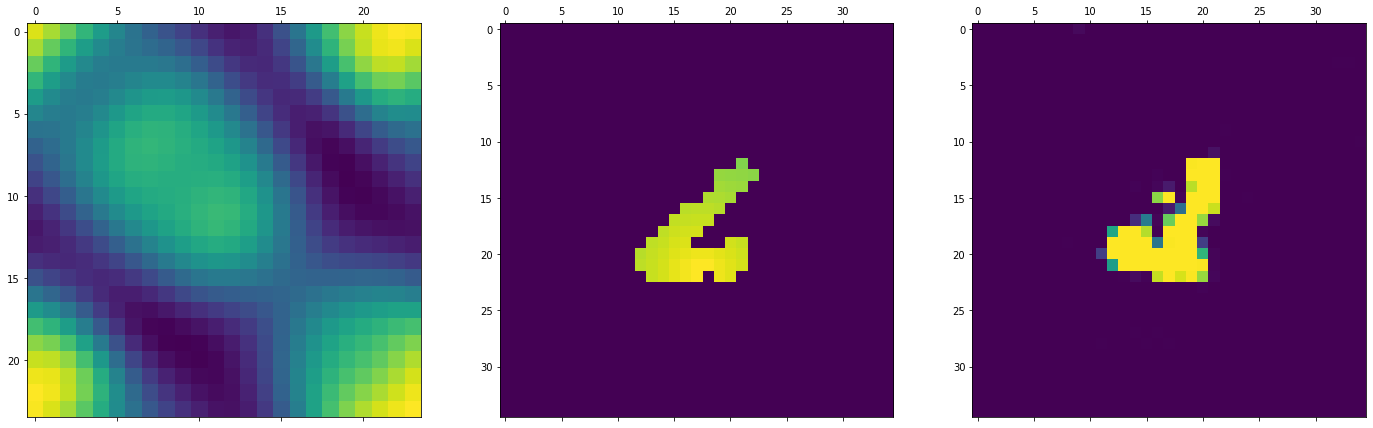

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[3])
axs[1].matshow(targetMNIST_test[3])
axs[2].matshow(pred1[3])

plt.show()

In [23]:
pred2 = model_unet.predict(field_test)

2/2 [==============================] - 0s 38ms/step


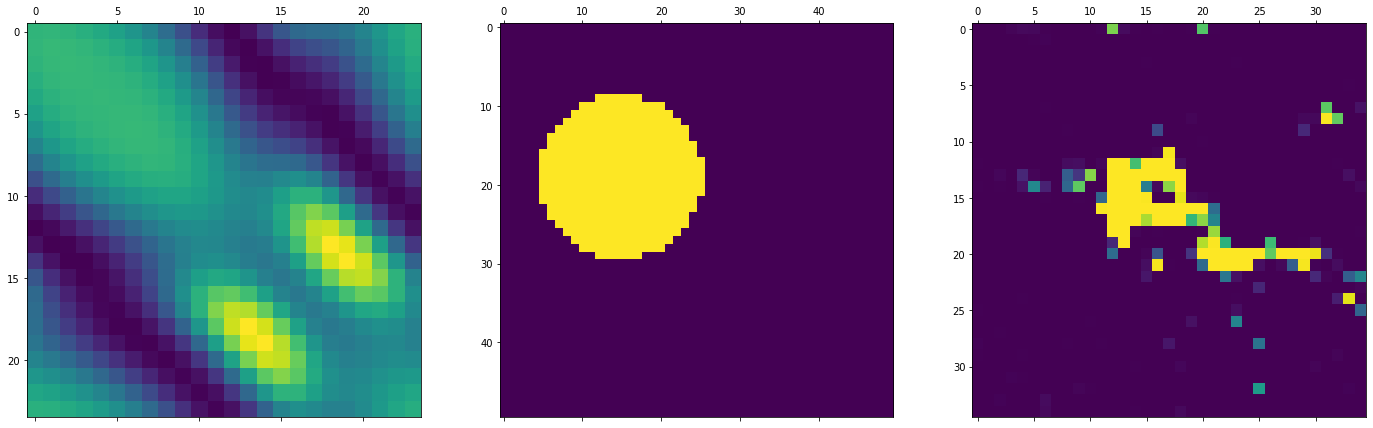

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(field_test[1])
axs[1].matshow(target_test[1])
axs[2].matshow(pred2[1])

plt.show()

In [67]:
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = 'accuracy')
model.fit(x = fieldMNIST_train, y = targetMNIST_train, batch_size = 20, epochs = total_epoch, callbacks = [LearningRateScheduler(lr_scheduler)])

In [68]:
adam_opt_model = Adam_opt(model_unet)

Epoch 1/200
21/21 [==============================] - 8s 267ms/step - loss: 0.1009 - accuracy: 0.9455 - lr: 1.0000e-06
Epoch 2/200
21/21 [==============================] - 6s 267ms/step - loss: 0.0982 - accuracy: 0.9459 - lr: 9.7712e-07
Epoch 3/200
21/21 [==============================] - 6s 277ms/step - loss: 0.0970 - accuracy: 0.9459 - lr: 9.5477e-07
Epoch 4/200
 3/21 [===>..........................] - ETA: 4s - loss: 0.0934 - accuracy: 0.9500

KeyboardInterrupt: 